# Image caption runs with various hyperparameters
# SGD optimization
# Run for 3.5h

## Read data

In [1]:
%matplotlib inline
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import subprocess
import os
import seaborn as sns
import lib

In [2]:
!ls logs/fixtime/SGD/

BSLRWD_time_limit50400s      LRWDchange_time_limit3600s
BSLRchange_time_limit3000s   SSS100_SG0.7_time_limit1800s
BS_time_limit10800s          SSS25_SG0.5_time_limit1800s
BS_time_limit3600s           WDchange_time_limit1200s
LRWD_time_limit12600.0s      time_limit120s
LRWD_time_limit12600s        time_limit1800s
LRWD_time_limit18000s


In [3]:
logdir = "logs/fixtime/SGD/LRWD_time_limit12600s"

In [4]:
filename_pattern=re.compile(r"imagecaption_.*\.log")
files=[]
comm = "ls -1 "+logdir
proc = subprocess.Popen(comm.split(" "),
                     stdout=subprocess.PIPE,stderr=subprocess.STDOUT)
for line in iter(proc.stdout.readline,b''):
    m = filename_pattern.match(line)
    if m:
        files.append(os.path.abspath(os.path.join(logdir,line)))
print len(files)
f = open(files[0].strip(" \n"))
print os.path.basename(files[0])
for i in range(0,12):    
    print f.readline(),
f.close()

6
imagecaption_b40_l1.05_wd0.0001_smp1000_00.log

b40 l1.05
GPU: GeForce GTX TITAN X, 12207 MiB

NV_GPU=4
Runnning command nvidia-docker run -t --rm --shm-size 8G -v /data1/peter/image-caption-applications:/workspace/image_caption -v /data1/peter/image-caption-applications/.torch:/root/.torch -w /workspace/image_caption image-caption /workspace/image_caption/init_container.sh python train_gen_fixtime_SGD.py --early_stopping -v --scheduler_step_size 300 --scheduler_gamma 0.8 --batch_size 40 -l 1.05 --weight_decay 0.0001 --model resnet50 --use_samples 1000 --time_limit 12600
In container
Running python train_gen_fixtime_SGD.py --early_stopping -v --scheduler_step_size 300 --scheduler_gamma 0.8 --batch_size 40 -l 1.05 --weight_decay 0.0001 --model resnet50 --use_samples 1000 --time_limit 12600
Namespace(batch_size=40, beam_size=5, config_file='./config/model_gen.json', cuda=True, disable_cuda=False, disable_shuffle=False, early_stopping=True, first_save=5, image_dir='./data/mscoco', learn

In [5]:
batch_learn_pattern = re.compile(r"_b(\d+)_l([0-9\.]+)_wd([0-9\.e\-]+)_smp\d+_(\d+)") # Match against file name
output_pattern = re.compile(r"^(\d+),\s*([0-9\.]+),\s*([0-9\.]+)")
LR_pattern = re.compile(r"^Generator scheduler LR: \[([0-9\.e\-]+)\]")
validation_pattern = re.compile(r"^{'Bleu_1':\s*([0-9e\-\.]+),\s*'Bleu_2':\s*([0-9e\-\.]+),\s*'Bleu_3':\s*([0-9e\-\.]+),\s*'Bleu_4':\s*([0-9e\-\.]+),\s*'ROUGE_L':\s*([0-9e\-\.]+),\s*'CIDEr':\s*([0-9e\-\.]+)}")

# Read minibatch size and 1st epoch time from files.
# Store in a DataFrame.
def fileToDF(logfile, debug=False):
    global output_pattern, batch_learn_pattern, validation_pattern
    
    logfile = logfile.strip(" \n")
    filename = os.path.basename(logfile)
    if debug: print "FILE",filename
    batch = 0
    learn = 0 # Initial value of LR
    epoch_lr = 0  # LR chainging with epochs
    wd = 0
    run = 0
    m = batch_learn_pattern.search(filename)
    if m:
        batch = int(m.group(1))
        learn = float(m.group(2))
        epoch_lr = learn
        wd = float(m.group(3))
        run = int(m.group(4))
        if debug: print "BS,LR,WR,run:",batch,learn,wd,run
    
    with open(logfile,"r") as f:
        lines = f.readlines()
        time = 0
        epoch = 0
        ind = 0
        ind_v = 0 # DataFrame row number (index) for df_validation
        df_epochtime = pd.DataFrame(data=None,columns=["batch","lr","run","wd",
                                                       "epoch","time","loss","epoch_lr"])
        df_validation = pd.DataFrame(data=None,columns=["batch","lr","run","wd",
                                                        "bleu1","bleu2","bleu3","bleu4",
                                                        "rouge","cider"])
        for line in lines:
            s = line.strip(' \n')            
            m2 = output_pattern.match(s)
            if m2:
                # Use only last line from file (with max epoch counter)
                #if debug: print line,                    
                epoch = int(m2.group(1))
                time += float(m2.group(2))  # Time per epoch must be summed
                loss = float(m2.group(3))
                #if debug: print "BS,LR,WD,run,epoch,time,loss:",batch,learn,wd,run,epoch,time,loss
                df_epochtime.loc[ind] = [batch,learn,run,wd,epoch,time,loss,epoch_lr]
                ind += 1
            else:
                m3 = validation_pattern.match(s)
                if m3:
                    if debug: print line,
                    bl1 = float(m3.group(1))
                    bl2 = float(m3.group(2))
                    bl3 = float(m3.group(3))
                    bl4 = float(m3.group(4))
                    rouge = float(m3.group(5))
                    cider = float(m3.group(6))
                    if debug: print "Bleu, Rouge, CIDEr:",bl1,bl2,bl3,bl4,rouge,cider
                    df_validation.loc[ind_v] = [batch,learn,run,wd,
                                                bl1,bl2,bl3,bl4,
                                                rouge, cider]
                    ind_v += 1
                else:
                    # Parse lines with LR info like this:
                    # Generator scheduler LR: [0.5389999999999999]
                    m4 = LR_pattern.match(s)
                    if m4:
                        epoch_lr = float(m4.group(1))
                        if debug: print "LR:",learn
                        

    return (df_epochtime, df_validation)

In [10]:
def readLogs(logdir, debug=False, maxfiles=10000000):
    global filename_pattern
    files=[]
    comm = "ls -1 "+logdir
    proc = subprocess.Popen(comm.split(" "),
                         stdout=subprocess.PIPE,stderr=subprocess.STDOUT)
    for line in iter(proc.stdout.readline,b''):
        m = filename_pattern.match(line)
        if m:
            files.append(os.path.abspath(os.path.join(logdir,line)))
            
    #if debug: print "files:",files
    df_epochtime = pd.DataFrame(data=None,columns=["batch","lr","run","wd","epoch","time","loss","epoch_lr"])
    df_validation = pd.DataFrame(data=None,columns=["batch","lr","run","wd",
                                                        "bleu1","bleu2","bleu3","bleu4",
                                                        "rouge","cider"])
    filecounter=0
    for file in files:
        if debug: print file
        df_e1,df_v1 = fileToDF(file,debug)
        if len(df_e1) > 0:
            df_epochtime = pd.concat([df_epochtime,df_e1],ignore_index=True)
        if len(df_v1) > 0:
            df_validation = pd.concat([df_validation,df_v1],ignore_index=True)
        filecounter +=1
        if filecounter>=maxfiles:
            return df
    return (df_epochtime, df_validation)

In [11]:
print logdir
df_epochtime,df_validation = readLogs(logdir, False)
print df_validation.shape, df_epochtime.shape

logs/fixtime/SGD/LRWD_time_limit12600s
(4, 10) (4600, 8)


In [12]:
df_validation[["batch","run"]] = df_validation[["batch","run"]].astype(int)
df_epochtime[["batch","run"]] = df_epochtime[["batch","run"]].astype(int)
df_validation

,batch,lr,run,wd,bleu1,bleu2,bleu3,bleu4,rouge,cider
0,40,1.05,0,0.00010,2.181625e-11,1.245702e-11,9.002813e-12,6.634219e-12,0.007281,0.000051
1,40,1.05,0,0.00001,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.005394,0.000000
2,40,1.10,0,0.00010,4.834645e-19,2.514429e-19,1.717987e-19,1.184607e-19,0.006526,0.000015
3,40,1.10,0,0.00001,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.005394,0.000000


## Validation score

In [13]:
print df_validation.shape
print "batch sizes:",df_validation["batch"].unique()
df_validation.head()

(4, 10)
batch sizes: [40]


,batch,lr,run,wd,bleu1,bleu2,bleu3,bleu4,rouge,cider
0,40,1.05,0,0.00010,2.181625e-11,1.245702e-11,9.002813e-12,6.634219e-12,0.007281,0.000051
1,40,1.05,0,0.00001,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.005394,0.000000
2,40,1.10,0,0.00010,4.834645e-19,2.514429e-19,1.717987e-19,1.184607e-19,0.006526,0.000015
3,40,1.10,0,0.00001,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.005394,0.000000


### Count runs for each BS x WD x LR combination

In [14]:
count_df = df_validation.copy()
count_df = count_df[["batch","lr","wd","run"]]
count_df["count"] =  count_df.groupby(["batch","lr","wd"])["run"].transform(len)
count_df.drop(["run"],axis=1,inplace=True)
count_df.head()

,batch,lr,wd,count
0,40,1.05,0.00010,1
1,40,1.05,0.00001,1
2,40,1.10,0.00010,1
3,40,1.10,0.00001,1


In [15]:
df_count = count_df.pivot(index="wd",columns="lr",values="count")
df_count.head()

lr,1.05,1.1
wd,,
0.00001,1,1
0.00010,1,1


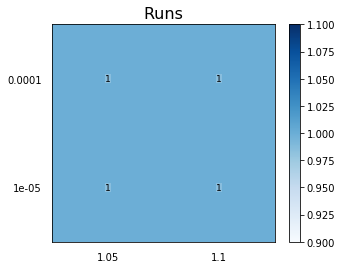

In [16]:
plt.rcParams['figure.figsize'] = 5,4
fig, ax = plt.subplots()
lib.plotHeatMap(df_count,"Runs","Blues",ax=ax,format="d")

### Plot Validation Scores

In [17]:
# Take average between runs
df_mean = df_validation.groupby(["batch","lr","wd"]).mean().reset_index().drop(["run"],axis=1)
df_mean.head()

,batch,lr,wd,bleu1,bleu2,bleu3,bleu4,rouge,cider
0,40,1.05,0.00001,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.005394,0.000000
1,40,1.05,0.00010,2.181625e-11,1.245702e-11,9.002813e-12,6.634219e-12,0.007281,0.000051
2,40,1.10,0.00001,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.005394,0.000000
3,40,1.10,0.00010,4.834645e-19,2.514429e-19,1.717987e-19,1.184607e-19,0.006526,0.000015


In [18]:
df_cider = df_mean.pivot_table(index="wd",columns="lr",values="cider")
df_rouge = df_mean.pivot_table(index="wd",columns="lr",values="rouge")
df_bleu1 = df_mean.pivot_table(index="wd",columns="lr",values="bleu1")
df_bleu2 = df_mean.pivot_table(index="wd",columns="lr",values="bleu2")
df_bleu3 = df_mean.pivot_table(index="wd",columns="lr",values="bleu3")
df_bleu4 = df_mean.pivot_table(index="wd",columns="lr",values="bleu4")
df_cider.head()

lr,1.05,1.1
wd,,
0.00001,0.000000,0.000000
0.00010,0.000051,0.000015


/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


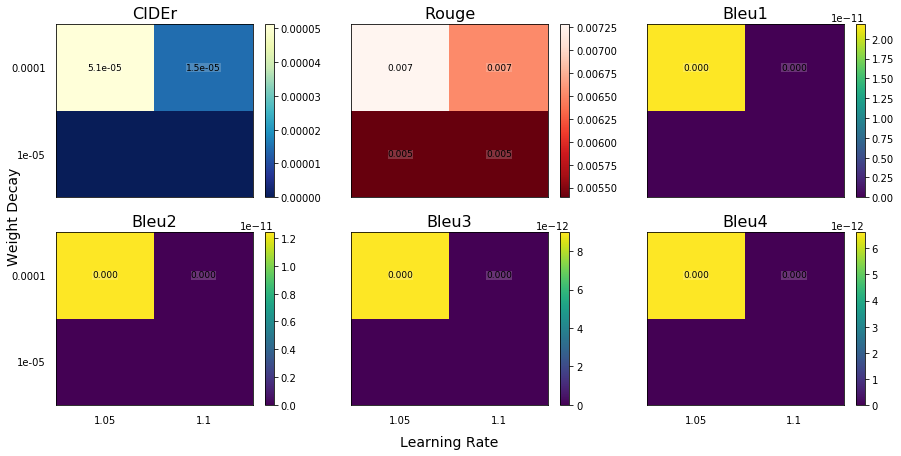

In [19]:
plt.rcParams['figure.figsize'] = 15,7
fig, ax = plt.subplots(2,3,sharex=True,sharey=True)
lib.plotHeatMap(df_cider,"CIDEr","YlGnBu_r",ax=ax[0,0],format=".1e")
lib.plotHeatMap(df_rouge,"Rouge","Reds_r",ax=ax[0,1])
lib.plotHeatMap(df_bleu1,"Bleu1",ax=ax[0,2])
lib.plotHeatMap(df_bleu2,"Bleu2",ax=ax[1,0])
lib.plotHeatMap(df_bleu3,"Bleu3",ax=ax[1,1])
lib.plotHeatMap(df_bleu4,"Bleu4",ax=ax[1,2])
ax[1,1].set_xlabel("Learning Rate",size=14)
#fig.text(0.5, 0.08, 'Learning rate', ha='center',fontsize=14)
fig.text(0.08, 0.5, 'Weight Decay', va='center', rotation='vertical',fontsize=14)
fig.show()

## Loss and epochs heatmap

In [20]:
print df_epochtime.shape
df_epochtime.head()

(4600, 8)


,batch,lr,run,wd,epoch,time,loss,epoch_lr
0,40,1.05,0,0.0001,1.0,11.201498,8.982799,1.05
1,40,1.05,0,0.0001,2.0,21.900085,8.969650,1.05
2,40,1.05,0,0.0001,3.0,32.660700,8.977294,1.05
3,40,1.05,0,0.0001,4.0,43.510380,8.966067,1.05
4,40,1.05,0,0.0001,5.0,54.746431,8.955637,1.05


In [21]:
# Make new column with max epoch for each (batch, lr, run) combination
df_maxepoch = df_epochtime.copy()
df_maxepoch["max_epoch"] = df_maxepoch.groupby(["batch","lr","wd","run"])["epoch"].transform(np.max)
#df_maxepoch = df_maxepoch.sort_values(by=["batch","lr","wd","run"],ascending=True)
df_maxepoch.head()

,batch,lr,run,wd,epoch,time,loss,epoch_lr,max_epoch
0,40,1.05,0,0.0001,1.0,11.201498,8.982799,1.05,1150.0
1,40,1.05,0,0.0001,2.0,21.900085,8.969650,1.05,1150.0
2,40,1.05,0,0.0001,3.0,32.660700,8.977294,1.05,1150.0
3,40,1.05,0,0.0001,4.0,43.510380,8.966067,1.05,1150.0
4,40,1.05,0,0.0001,5.0,54.746431,8.955637,1.05,1150.0


In [22]:
df_maxepoch = df_maxepoch[df_maxepoch["max_epoch"] == df_maxepoch["epoch"]]
df_maxepoch.head()

,batch,lr,run,wd,epoch,time,loss,epoch_lr,max_epoch
1149,40,1.05,0,0.00010,1150.0,12606.593275,8.366078,0.5376,1150.0
2299,40,1.05,0,0.00001,1150.0,12604.373761,7.986740,0.5376,1150.0
3449,40,1.10,0,0.00010,1150.0,12605.516542,8.415232,0.5632,1150.0
4599,40,1.10,0,0.00001,1150.0,12606.551797,7.977431,0.5632,1150.0


In [23]:
# Take average between runs
df_mean = df_maxepoch.groupby(["batch","lr","wd"]).mean().reset_index().drop(["run","max_epoch","time","epoch_lr"],axis=1)
df_mean.head()

,batch,lr,wd,epoch,loss
0,40,1.05,0.00001,1150.0,7.986740
1,40,1.05,0.00010,1150.0,8.366078
2,40,1.10,0.00001,1150.0,7.977431
3,40,1.10,0.00010,1150.0,8.415232


In [24]:
df_mean.describe()

,batch,lr,wd,epoch,loss
count,4.0,4.000000,4.000000,4.0,4.000000
mean,40.0,1.075000,0.000055,1150.0,8.186370
std,0.0,0.028868,0.000052,0.0,0.236770
min,40.0,1.050000,0.000010,1150.0,7.977431
25%,40.0,1.050000,0.000010,1150.0,7.984413
50%,40.0,1.075000,0.000055,1150.0,8.176409
75%,40.0,1.100000,0.000100,1150.0,8.378366
max,40.0,1.100000,0.000100,1150.0,8.415232


In [25]:
loss_df = df_mean[['lr','batch',"wd",'loss']]
epoch_df = df_mean[['lr','batch',"wd",'epoch']]

In [26]:
loss_T = loss_df.pivot_table(index="wd",columns="lr",values="loss")
epoch_T = epoch_df.pivot_table(index="wd",columns="lr",values="epoch")

In [27]:
# Create custom colormap
colors= [u'#24368Eff',
         u'#5BBEC0ff',
         u'#F4FAC4ff']
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("combined", colors, N=256)

Text(0.5,0,u'Learning Rate')

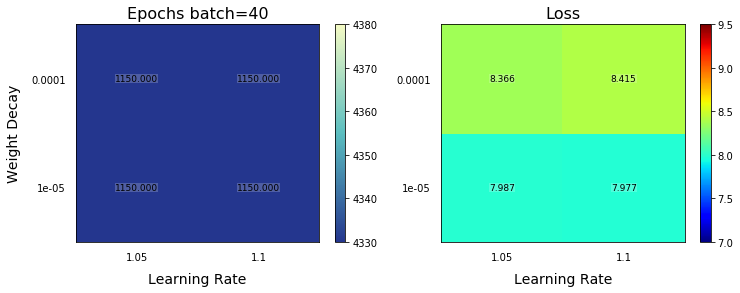

In [28]:
plt.rcParams['figure.figsize'] = (12,4)
fig,axarr = plt.subplots(1,2)
lib.plotHeatMap(epoch_T,"Epochs batch="+str(df_mean["batch"][0]),cmap,ax = axarr[0],zrange=(4330,4380))
lib.plotHeatMap(loss_T,"Loss","jet",ax=axarr[1],zrange=(7,9.5))
axarr[0].set_ylabel("Weight Decay",size=14)
axarr[0].set_xlabel("Learning Rate",size=14)
axarr[1].set_xlabel("Learning Rate",size=14)

## Plot Loss graphs for each BS x LR x WD combination

In [29]:
df_epochtime.head()

,batch,lr,run,wd,epoch,time,loss,epoch_lr
0,40,1.05,0,0.0001,1.0,11.201498,8.982799,1.05
1,40,1.05,0,0.0001,2.0,21.900085,8.969650,1.05
2,40,1.05,0,0.0001,3.0,32.660700,8.977294,1.05
3,40,1.05,0,0.0001,4.0,43.510380,8.966067,1.05
4,40,1.05,0,0.0001,5.0,54.746431,8.955637,1.05


In [30]:
# Take average between runs
df_mean_epo = df_epochtime.groupby(["lr","batch","wd","epoch","epoch_lr"]).mean().reset_index().drop(["run"],axis=1)
df_mean_epo["epoch"] = df_mean_epo["epoch"].astype(int)
print df_mean_epo.dtypes
#df_mean_epo.describe()
df_mean_epo.head()

lr          float64
batch         int64
wd          float64
epoch         int64
epoch_lr    float64
time        float64
loss        float64
dtype: object


,lr,batch,wd,epoch,epoch_lr,time,loss
0,1.05,40,0.00001,1,1.05,11.388611,8.990243
1,1.05,40,0.00001,2,1.05,22.103620,8.981367
2,1.05,40,0.00001,3,1.05,32.787159,8.971182
3,1.05,40,0.00001,4,1.05,43.657948,8.959339
4,1.05,40,0.00001,5,1.05,54.356581,8.960225


In [31]:
print df_mean_epo["wd"].unique()
df_mean_epo = df_mean_epo.sort_values(by=["wd","batch"],ascending=False)
#df_mean_epo = df_mean_epo.sort_values(by=["lr","epoch"],ascending=True)
print "wd:",df_mean_epo["wd"].unique()
# Scale epoch_lr
df_mean_epo["epoch_lr"] = df_mean_epo["epoch_lr"]
#print df_mean_epo["wd"].values
df_mean_epo.head(5)

[  1.00000000e-05   1.00000000e-04]
wd: [  1.00000000e-04   1.00000000e-05]


,lr,batch,wd,epoch,epoch_lr,time,loss
1150,1.05,40,0.0001,1,1.05,11.201498,8.982799
1151,1.05,40,0.0001,2,1.05,21.900085,8.969650
1152,1.05,40,0.0001,3,1.05,32.660700,8.977294
1153,1.05,40,0.0001,4,1.05,43.510380,8.966067
1154,1.05,40,0.0001,5,1.05,54.746431,8.955637


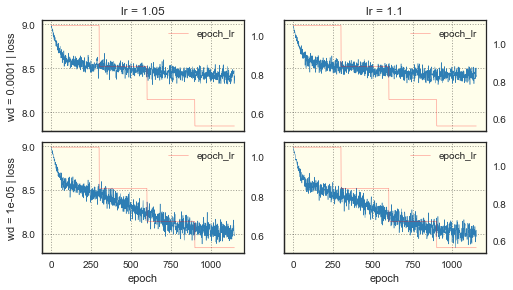

In [32]:
# Plot using Seaborn FacetGrid
# Set Seaborn global parameters
sns.set(font_scale=1)
#sns.set_style("white",{'axes.grid': True, 'grid.color': (0,0,0),'grid.linestyle':u':'})
sns.set_style("white")
#print sns.axes_style()

# Plot using "tab10" matplotlib colormap

# major_xticks = np.arange(0,176,50)
# minor_xticks = np.arange(0,176,25)
# major_yticks = np.arange(5,8.1,1)
# minor_yticks = np.arange(5,8.1,0.5)
#with sns.color_palette("tab10"):

fg = sns.FacetGrid(df_mean_epo,row="wd",col="lr",
                     row_order=df_mean_epo["wd"].unique(),
                     size=2.1,aspect=1.7,
                     #xlim=(0,176),
                     #ylim=(8.6,9.1),
                     #margin_titles=True,
                     subplot_kws={"facecolor":"#FFFEEB"})

fg.map(plt.plot,"epoch","loss",ls="-",linewidth=.5,color="#2E7EB4")
#fg.map(plt.plot,"epoch","epoch_lr",ls="-",linewidth=.5,alpha=0.5,color="red")

# print "FacetGrid:"
# for key in fg.__dict__.keys():
#     print key,type(fg.__dict__[key])
#print fg.axes.shape, fg.axes.size
#axes = fg.axes.reshape(fg.axes.size)    

once=False
for ax_arr in np.nditer(fg.axes,flags=["refs_ok"]):
    ax = ax_arr.item()
#         ax.set_xticks(major_xticks)
#         ax.set_yticks(major_yticks)
#         ax.set_xticks(minor_xticks, minor=True)        
#         ax.set_yticks(minor_yticks, minor=True)
    ax.grid(which="major",ls=":",alpha=0.25, color="black")
    ax.grid(which="minor",ls=":",alpha=0.15, color="black")
    #ax.yaxis.labelpad = 25    
    #print "off:",ax.yaxis.offsetText
#     if once:
#         print "Ax:",ax.yaxis.__dict__.keys()
#         for key in ax.yaxis.__dict__.keys():
#              print key, type(ax.yaxis.__dict__[key]),ax.yaxis.__dict__[key]
#         once = False

for i, axes_row in enumerate(fg.axes):
    for j, axes_col in enumerate(axes_row):
        row, col = axes_col.get_title().split('|')

        if i == 0:
            axes_col.set_title(col.strip())
        else:
            axes_col.set_title('')

        if j == 0:
            ylabel = axes_col.get_ylabel()
            axes_col.set_ylabel(row.strip() + ' | ' + ylabel)
    
for (i,j,k), data in fg.facet_data():
    ax = fg.facet_axis(i, j)
    ax2 = ax.twinx()
    data.plot(x="epoch",y="epoch_lr",ax=ax2,linewidth=.5,color="red",alpha=.5)

    
#fg.fig.subplots_adjust(right=.9)
plt.subplots_adjust(hspace=0.1, wspace=0.2)
plt.show()